In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws, row_number
from pyspark.sql.window import Window  # <-- This import was missing
# Initialize Spark session
spark = SparkSession.builder.appName("F1 Data Analysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 20:08:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
data_path = "data/"

# Load CSV files into DataFrames with the updated path
constructor_performance_df = spark.read.csv(data_path + "Constructor_Performance.csv", header=True, inferSchema=True)
constructor_rankings_df = spark.read.csv(data_path + "Constructor_Rankings.csv", header=True, inferSchema=True)
driver_details_df = spark.read.csv(data_path + "Driver_Details.csv", header=True, inferSchema=True)
driver_rankings_df = spark.read.csv(data_path + "Driver_Rankings.csv", header=True, inferSchema=True)
lap_timings_df = spark.read.csv(data_path + "Lap_Timings.csv", header=True, inferSchema=True)
pit_stop_records_df = spark.read.csv(data_path + "Pit_Stop_Records.csv", header=True, inferSchema=True)
qualifying_results_df = spark.read.csv(data_path + "Qualifying_Results.csv", header=True, inferSchema=True)
race_results_df = spark.read.csv(data_path + "Race_Results.csv", header=True, inferSchema=True)
race_schedule_df = spark.read.csv(data_path + "Race_Schedule.csv", header=True, inferSchema=True)
race_status_df = spark.read.csv(data_path + "Race_Status.csv", header=True, inferSchema=True)
season_summaries_df = spark.read.csv(data_path + "Season_Summaries.csv", header=True, inferSchema=True)
sprint_race_results_df = spark.read.csv(data_path + "Sprint_Race_Results.csv", header=True, inferSchema=True)
team_details_df = spark.read.csv(data_path + "Team_Details.csv", header=True, inferSchema=True)
track_information_df = spark.read.csv(data_path + "Track_Information.csv", header=True, inferSchema=True)


In [3]:
# Join race_results_df with driver_details_df on driverId

from pyspark.sql.functions import concat_ws

# Concatenate forename and surname to create a full name
driver_details_with_full_name = driver_details_df.withColumn("driverName", concat_ws(" ", driver_details_df["forename"], driver_details_df["surname"]))

# Top 5 Drivers with the Most Wins and their names
top_drivers_by_wins = race_results_df.filter(race_results_df["position"] == 1) \
    .groupBy("driverId") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5)

# Join with driver details to get the driver names
top_drivers_with_names = top_drivers_by_wins.join(driver_details_with_full_name, "driverId") \
    .select("driverName", "count") \
    .orderBy("count", ascending=False)

top_drivers_with_names.show()

+------------------+-----+
|        driverName|count|
+------------------+-----+
|    Lewis Hamilton|  104|
|Michael Schumacher|   91|
|    Max Verstappen|   61|
|  Sebastian Vettel|   53|
|       Alain Prost|   51|
+------------------+-----+



In [4]:
# Concatenate forename and surname to create a full name
driver_details_with_full_name = driver_details_df.withColumn("driverName", concat_ws(" ", driver_details_df["forename"], driver_details_df["surname"]))

# Top 5 Drivers with the Most Wins
top_drivers_by_wins = race_results_df.filter(race_results_df["position"] == 1) \
    .groupBy("driverId") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5)

# Join with driver details to get the driver names
top_drivers_with_names = top_drivers_by_wins.join(driver_details_with_full_name, "driverId") \
    .select("driverId", "driverName", "count") \
    .orderBy("count", ascending=False)

# Load the race schedule for race dates and names
# Assuming race_schedule_df has "Race_ID", "Race_Name", "Date", and "Year" columns
# Load the race schedule for race dates and names
# Updated to use the correct column names: "raceId", "name", "date", "year"
# Load the race schedule for race dates and names
# Updated to use the correct column names: "raceId", "name", "date", "year"
race_schedule_with_info = race_schedule_df.select("raceId", "name", "date", "year")

# Filter for top 5 drivers
top_5_drivers = top_drivers_with_names.select("driverId").rdd.flatMap(lambda x: x).collect()

# Rename raceId in one of the DataFrames to avoid ambiguity
race_results_df_renamed = race_results_df.withColumnRenamed("raceId", "raceResultId")

# Get all the race wins for the top 5 drivers
race_wins = race_results_df_renamed.filter(race_results_df_renamed["position"] == 1) \
    .filter(race_results_df_renamed["driverId"].isin(top_5_drivers)) \
    .join(race_schedule_with_info, race_results_df_renamed["raceResultId"] == race_schedule_with_info["raceId"]) \
    .select("driverId", "raceId", "name", "year", "date", "position")

# Add row numbers to each win per driver (ordered by date descending) to get the last 5 wins
window_spec = Window.partitionBy("driverId").orderBy(race_wins["date"].desc())
race_wins_with_row_number = race_wins.withColumn("row_number", row_number().over(window_spec))

# Filter to only keep the last 5 wins for each driver
last_5_wins = race_wins_with_row_number.filter(race_wins_with_row_number["row_number"] <= 5)

# Join with driver details to get driver names
last_5_wins_with_names = last_5_wins.join(driver_details_with_full_name, "driverId") \
    .select("driverName", "raceId", "name", "year", "date", "row_number") \
    .orderBy("driverName", "date", ascending=False)

# Show the results
last_5_wins_with_names.show(truncate=False)

+------------------+------+-------------------------+----+----------+----------+
|driverName        |raceId|name                     |year|date      |row_number|
+------------------+------+-------------------------+----+----------+----------+
|Sebastian Vettel  |1024  |Singapore Grand Prix     |2019|2019-09-22|1         |
|Sebastian Vettel  |1001  |Belgian Grand Prix       |2018|2018-08-26|2         |
|Sebastian Vettel  |998   |British Grand Prix       |2018|2018-07-08|3         |
|Sebastian Vettel  |995   |Canadian Grand Prix      |2018|2018-06-10|4         |
|Sebastian Vettel  |990   |Bahrain Grand Prix       |2018|2018-04-08|5         |
|Michael Schumacher|68    |Chinese Grand Prix       |2006|2006-10-01|1         |
|Michael Schumacher|67    |Italian Grand Prix       |2006|2006-09-10|2         |
|Michael Schumacher|64    |German Grand Prix        |2006|2006-07-30|3         |
|Michael Schumacher|63    |French Grand Prix        |2006|2006-07-16|4         |
|Michael Schumacher|62    |U

In [5]:
# Aggregate points for each constructor
top_constructors = constructor_performance_df.groupBy("constructorId") \
    .agg({"points": "sum"}) \
    .orderBy("sum(points)", ascending=False)

# Join with team details to get constructor names
top_constructors_with_names = top_constructors.join(team_details_df, "constructorId") \
    .select("name", "sum(points)") \
    .orderBy("sum(points)", ascending=False)

top_constructors_with_names.show(truncate=False)


+--------------+-----------+
|name          |sum(points)|
+--------------+-----------+
|Ferrari       |10001.0    |
|Red Bull      |7621.0     |
|Mercedes      |7443.5     |
|McLaren       |6685.5     |
|Williams      |3630.0     |
|Renault       |1777.0     |
|Force India   |1098.0     |
|Team Lotus    |918.0      |
|Benetton      |861.5      |
|Lotus F1      |706.0      |
|Tyrrell       |621.0      |
|Brabham       |595.0      |
|Sauber        |557.0      |
|Toro Rosso    |500.0      |
|Aston Martin  |480.0      |
|Alpine F1 Team|457.0      |
|BRM           |439.0      |
|Ligier        |388.0      |
|AlphaTauri    |309.0      |
|BMW Sauber    |308.0      |
+--------------+-----------+
only showing top 20 rows



In [6]:
# Join race results with race schedule to get the year
race_times_with_year = race_results_df.join(race_schedule_df, "raceId") \
    .select("driverId", "raceId", "milliseconds", "year")

# Calculate average race time by driver and season
average_race_time = race_times_with_year.groupBy("driverId", "year") \
    .agg({"milliseconds": "avg"}) \
    .orderBy("avg(milliseconds)")

# Join with driver details to get driver names
average_race_time_with_names = average_race_time.join(driver_details_with_full_name, "driverId") \
    .select("driverName", "year", "avg(milliseconds)") \
    .orderBy("year", "avg(milliseconds)")

average_race_time_with_names.show(truncate=False)


+---------------------+----+-----------------+
|driverName           |year|avg(milliseconds)|
+---------------------+----+-----------------+
|Franco Comotti       |1950|NULL             |
|José Froilán González|1950|NULL             |
|Joie Chitwood        |1950|NULL             |
|Fred Agabashian      |1950|NULL             |
|Myron Fohr           |1950|NULL             |
|Maurice Trintignant  |1950|NULL             |
|Nello Pagani         |1950|NULL             |
|Cecil Green          |1950|NULL             |
|Brian Shawe Taylor   |1950|NULL             |
|Toni Branca          |1950|NULL             |
|Travis Webb          |1950|NULL             |
|Geoff Crossley       |1950|NULL             |
|Jerry Hoyt           |1950|NULL             |
|Raymond Sommer       |1950|NULL             |
|Sam Hanks            |1950|NULL             |
|Bill Cantrell        |1950|NULL             |
|Louis Chiron         |1950|NULL             |
|Duane Carter         |1950|NULL             |
|David Hampsh

In [8]:


# Find the fastest lap in each race and rename the aggregated column
fastest_laps = lap_timings_df.groupBy("raceId") \
    .agg({"milliseconds": "min"}) \
    .withColumnRenamed("min(milliseconds)", "milliseconds") \
    .orderBy("raceId")

# Join with the original lap timings to get the driverId based on the fastest milliseconds
fastest_laps_with_driver = fastest_laps.join(lap_timings_df, ["raceId", "milliseconds"])

# Join with driver details and race schedule to get driver names and race info
fastest_laps_with_names = fastest_laps_with_driver \
    .join(driver_details_with_full_name, "driverId") \
    .join(race_schedule_df, "raceId") \
    .select("name", "year", "raceId", "driverName", "milliseconds") \
    .orderBy("year", "milliseconds")

# Show the results
fastest_laps_with_names.show(truncate=False)



+---------------------+----+------+---------------------+------------+
|name                 |year|raceId|driverName           |milliseconds|
+---------------------+----+------+---------------------+------------+
|French Grand Prix    |1996|232   |Jacques Villeneuve   |78610       |
|Hungarian Grand Prix |1996|235   |Damon Hill           |80093       |
|European Grand Prix  |1996|227   |Damon Hill           |81363       |
|Brazilian Grand Prix |1996|225   |Damon Hill           |81547       |
|Canadian Grand Prix  |1996|231   |Jacques Villeneuve   |81916       |
|Portuguese Grand Prix|1996|238   |Jacques Villeneuve   |82873       |
|Monaco Grand Prix    |1996|229   |Jean Alesi           |85205       |
|Italian Grand Prix   |1996|237   |Michael Schumacher   |86110       |
|San Marino Grand Prix|1996|228   |Damon Hill           |88931       |
|British Grand Prix   |1996|233   |Jacques Villeneuve   |89288       |
|Argentine Grand Prix |1996|226   |Jean Alesi           |89413       |
|Austr

In [4]:
from pyspark.sql.functions import col, min, max

# Find the longest and shortest pit stops in each race and rename the aggregated columns
pit_stop_analysis = pit_stop_records_df.groupBy("raceId") \
    .agg(min("duration").alias("min_duration"), max("duration").alias("max_duration")) \
    .orderBy("raceId")

# Alias pit_stop_records_df to avoid ambiguity in raceId columns during joins
pit_stop_records_aliased = pit_stop_records_df.alias("records")

# Join with the original pit stop records to get the driverId based on the raceId and duration
pit_stop_analysis_with_driver = pit_stop_analysis.join(
    pit_stop_records_aliased,
    (pit_stop_analysis["raceId"] == col("records.raceId")) &
    ((pit_stop_analysis["min_duration"] == col("records.duration")) |
     (pit_stop_analysis["max_duration"] == col("records.duration")))
).select(pit_stop_analysis["raceId"], "records.driverId", "min_duration", "max_duration")

# Join with driver details and race schedule to get driver names and race info
driver_details_aliased = driver_details_with_full_name.alias("drivers")
race_schedule_aliased = race_schedule_df.alias("races")

pit_stop_analysis_with_names = pit_stop_analysis_with_driver \
    .join(driver_details_aliased, "driverId") \
    .join(race_schedule_aliased, pit_stop_analysis_with_driver["raceId"] == col("races.raceId")) \
    .select(
        pit_stop_analysis_with_driver["raceId"],
        "races.name", "races.year", "drivers.driverName", 
        "min_duration", "max_duration"
    ).orderBy("year", "min_duration")

# Show the results
pit_stop_analysis_with_names.show(truncate=False)


+------+---------------------+----+------------------+------------+------------+
|raceId|name                 |year|driverName        |min_duration|max_duration|
+------+---------------------+----+------------------+------------+------------+
|858   |Abu Dhabi Grand Prix |2011|Pastor Maldonado  |12.897      |43.574      |
|858   |Abu Dhabi Grand Prix |2011|Jaime Alguersuari |12.897      |43.574      |
|851   |Hungarian Grand Prix |2011|Lewis Hamilton    |13.173      |49.849      |
|851   |Hungarian Grand Prix |2011|Jérôme d'Ambrosio |13.173      |49.849      |
|843   |Chinese Grand Prix   |2011|Sergio Pérez      |13.900      |33.827      |
|843   |Chinese Grand Prix   |2011|Timo Glock        |13.900      |33.827      |
|852   |Belgian Grand Prix   |2011|Rubens Barrichello|13.914      |47.753      |
|852   |Belgian Grand Prix   |2011|Timo Glock        |13.914      |47.753      |
|844   |Turkish Grand Prix   |2011|Pastor Maldonado  |13.925      |56.611      |
|844   |Turkish Grand Prix  

In [17]:
# Join driver rankings with race schedule to get the year
driver_ranking_with_year = driver_rankings_df.join(race_schedule_df, "raceId") \
    .select("driverId", "position", "year")

# Calculate average rank by year for each driver
driver_ranking_evolution = driver_ranking_with_year.groupBy("driverId", "year") \
    .agg({"position": "avg"}) \
    .orderBy("year", "avg(position)")

# Join with driver details to get driver names
driver_ranking_evolution_with_names = driver_ranking_evolution.join(driver_details_with_full_name, "driverId") \
    .select("driverName", "year", "avg(position)") \
    .orderBy("year", "avg(position)")

driver_ranking_evolution_with_names.show(truncate=False)


+------------------+----+------------------+
|driverName        |year|avg(position)     |
+------------------+----+------------------+
|Nino Farina       |1950|1.2857142857142858|
|Luigi Fagioli     |1950|2.5714285714285716|
|Juan Fangio       |1950|3.7142857142857144|
|Johnnie Parsons   |1950|4.6               |
|Alberto Ascari    |1950|5.166666666666667 |
|Louis Rosier      |1950|6.571428571428571 |
|Bill Holland      |1950|6.6               |
|Reg Parnell       |1950|8.285714285714286 |
|Louis Chiron      |1950|9.714285714285714 |
|Prince Bira       |1950|10.142857142857142|
|Yves Cabantous    |1950|10.571428571428571|
|Mauri Rose        |1950|11.0              |
|Raymond Sommer    |1950|12.166666666666666|
|Dorino Serafini   |1950|13.0              |
|Cecil Green       |1950|14.4              |
|Felice Bonetto    |1950|16.5              |
|Bob Gerard        |1950|16.571428571428573|
|Tony Bettenhausen |1950|17.6              |
|Joie Chitwood     |1950|18.6              |
|Philippe 

In [18]:
# Join constructor performance with race schedule to get the year
constructor_performance_with_year = constructor_performance_df.join(race_schedule_df, "raceId") \
    .select("constructorId", "points", "year")

# Sum points per constructor and year
top_teams_per_season = constructor_performance_with_year.groupBy("constructorId", "year") \
    .agg({"points": "sum"}) \
    .orderBy("year", "sum(points)", ascending=False)

# Join with team details to get constructor names
top_teams_per_season_with_names = top_teams_per_season.join(team_details_df, "constructorId") \
    .select("name", "year", "sum(points)") \
    .orderBy("year", "sum(points)", ascending=False)

top_teams_per_season_with_names.show(truncate=False)


+--------------+----+-----------+
|name          |year|sum(points)|
+--------------+----+-----------+
|Red Bull      |2024|373.0      |
|Ferrari       |2024|302.0      |
|McLaren       |2024|295.0      |
|Mercedes      |2024|221.0      |
|Aston Martin  |2024|68.0       |
|RB F1 Team    |2024|31.0       |
|Haas F1 Team  |2024|27.0       |
|Alpine F1 Team|2024|9.0        |
|Williams      |2024|4.0        |
|Sauber        |2024|0.0        |
|Red Bull      |2023|860.0      |
|Mercedes      |2023|409.0      |
|Ferrari       |2023|406.0      |
|McLaren       |2023|302.0      |
|Aston Martin  |2023|280.0      |
|Alpine F1 Team|2023|120.0      |
|Williams      |2023|28.0       |
|AlphaTauri    |2023|25.0       |
|Alfa Romeo    |2023|16.0       |
|Haas F1 Team  |2023|12.0       |
+--------------+----+-----------+
only showing top 20 rows



In [20]:
from pyspark.sql.functions import col, count, when

# Aggregating wins and total races for each driver
driver_wins = race_results_df.groupBy("driverId") \
    .agg(
        count("position").alias("total_races"), 
        count(when(col("position") == 1, True)).alias("wins")
    )

# Calculate win percentage
driver_win_percentage = driver_wins.withColumn(
    "win_percentage", 
    (col("wins") / col("total_races")) * 100
).orderBy(col("win_percentage").desc())

# Join with driver details to get driver names
driver_win_percentage_with_names = driver_win_percentage.join(
    driver_details_with_full_name, "driverId"
).select(
    "driverName", "total_races", "wins", "win_percentage"
).orderBy(col("win_percentage").desc())

# Show the results
driver_win_percentage_with_names.show(truncate=False)


+------------------+-----------+----+------------------+
|driverName        |total_races|wins|win_percentage    |
+------------------+-----------+----+------------------+
|Lee Wallard       |2          |1   |50.0              |
|Juan Fangio       |58         |24  |41.37931034482759 |
|Bill Vukovich     |5          |2   |40.0              |
|Alberto Ascari    |36         |13  |36.11111111111111 |
|Jim Clark         |73         |25  |34.24657534246575 |
|Max Verstappen    |197        |61  |30.96446700507614 |
|Lewis Hamilton    |344        |104 |30.23255813953488 |
|Michael Schumacher|308        |91  |29.545454545454547|
|Jackie Stewart    |100        |27  |27.0              |
|Ayrton Senna      |162        |41  |25.308641975308642|
|Alain Prost       |202        |51  |25.247524752475247|
|Stirling Moss     |73         |16  |21.91780821917808 |
|Bob Sweikert      |5          |1   |20.0              |
|Damon Hill        |122        |22  |18.0327868852459  |
|Sebastian Vettel  |300        

In [21]:
# Count occurrences of each race status
race_status_analysis = race_status_df.groupBy("status") \
    .count() \
    .orderBy("count", ascending=False)

race_status_analysis.show(truncate=False)


+---------------+-----+
|status         |count|
+---------------+-----+
|Did not qualify|1    |
|Withdrew       |1    |
|Engine         |1    |
|Driver unwell  |1    |
|Water leak     |1    |
|Suspension     |1    |
|+17 Laps       |1    |
|Out of fuel    |1    |
|Not restarted  |1    |
|Fuel system    |1    |
|+21 Laps       |1    |
|Damage         |1    |
|+6 Laps        |1    |
|+3 Laps        |1    |
|Throttle       |1    |
|Oil leak       |1    |
|Oil pressure   |1    |
|Eye injury     |1    |
|Launch control |1    |
|Water pump     |1    |
+---------------+-----+
only showing top 20 rows



In [22]:
# Calculate average qualifying position for each driver
average_qualifying_position = qualifying_results_df.groupBy("driverId") \
    .agg({"position": "avg"}) \
    .orderBy("avg(position)", ascending=True)

# Join with driver details to get driver names
average_qualifying_position_with_names = average_qualifying_position.join(driver_details_with_full_name, "driverId") \
    .select("driverName", "avg(position)") \
    .orderBy("avg(position)", ascending=True)

average_qualifying_position_with_names.show(truncate=False)


+------------------+------------------+
|driverName        |avg(position)     |
+------------------+------------------+
|Ayrton Senna      |1.0               |
|Lewis Hamilton    |3.8924418604651163|
|Max Verstappen    |4.771573604060913 |
|Nigel Mansell     |4.833333333333333 |
|Damon Hill        |5.372881355932203 |
|Michael Schumacher|5.666666666666667 |
|Gerhard Berger    |5.760869565217392 |
|Juan Pablo Montoya|6.03125           |
|Mika Häkkinen     |6.048387096774194 |
|Sebastian Vettel  |6.247491638795987 |
|Charles Leclerc   |6.2773722627737225|
|Nico Rosberg      |6.834951456310679 |
|Mark Webber       |7.316831683168317 |
|Jean Alesi        |7.467741935483871 |
|Valtteri Bottas   |7.468085106382978 |
|Lando Norris      |7.620689655172414 |
|Kimi Räikkönen    |7.654205607476635 |
|Fernando Alonso   |8.101333333333333 |
|Ralf Schumacher   |8.261682242990654 |
|Eddie Irvine      |8.265625          |
+------------------+------------------+
only showing top 20 rows



In [24]:
# Join driver and constructor standings by raceId
driver_constructor_correlation = driver_rankings_df.join(
    constructor_rankings_df, "raceId"
).select(
    "driverId", "constructorId", driver_rankings_df["position"].alias("driverRank"), constructor_rankings_df["position"].alias("constructorRank")
)

# Calculate correlation between driver rank and constructor rank
driver_constructor_correlation_result = driver_constructor_correlation.stat.corr("driverRank", "constructorRank")

# Output the correlation result
print(f"Correlation between driver rank and constructor rank: {driver_constructor_correlation_result}")


Correlation between driver rank and constructor rank: 0.08551347347670557


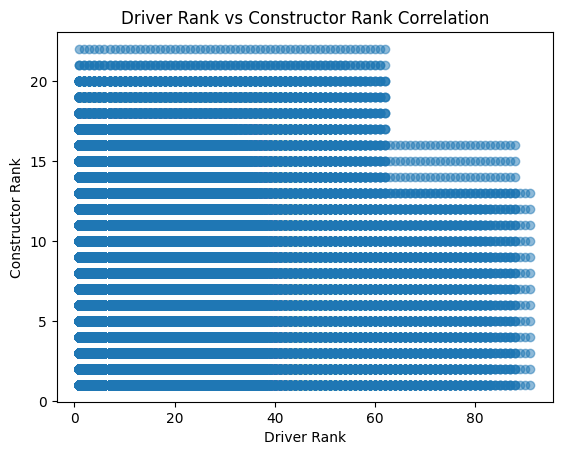

In [34]:
# Using PySpark to create a scatter plot without converting to Pandas
import matplotlib.pyplot as plt

# Collect data into a local Python list
driver_constructor_list = driver_constructor_correlation.select("driverRank", "constructorRank").collect()

# Unpack the data into two lists
driver_ranks = [row.driverRank for row in driver_constructor_list]
constructor_ranks = [row.constructorRank for row in driver_constructor_list]

# Create scatter plot
plt.scatter(driver_ranks, constructor_ranks, alpha=0.5)
plt.xlabel('Driver Rank')
plt.ylabel('Constructor Rank')
plt.title('Driver Rank vs Constructor Rank Correlation')
plt.show()
